# Bias Correction & Spacial Disaggregation Downscaling

The purpose of this notebook is to work as utility, taking low resolution climate model data and scaling it to high resolution while correcting for bias by comparison with historical observation data.

This notebook needs three things to run:
```
INPUT:
    1. Historical low res obs data 
    2. Historical low res model data
    3. low res model data of interest
OUTPUT:
    1. High-res version of the data from #3 above
```

In [23]:
import numpy as np
import xarray as xr
import pandas as pd
from tqdm import tqdm
import bcsd

# Obs data
You're going to need an observation dataset with the same grid as your training model dataset over the training period.

You can get a copy of the Princeton PRCP data by running the following:

```
wget http://hydrology.princeton.edu/data/pgf/v1/1.0deg/monthly/prcp_monthly_1948-2010.nc
```

# Model data
You'll need a model dataset that overlaps in time with the obs dataset. It doesnt have to be a perfect 1:1 match, but the more intersection there is the better the results will be.

You can get a copy of the INM-CM4 data by running the following:

```
wget https://esgf-data1.llnl.gov/thredds/fileServer/css03_data/CMIP6/CMIP/INM/INM-CM4-8/historical/r1i1p1f1/Amon/pr/gr1/v20190530/pr_Amon_INM-CM4-8_historical_r1i1p1f1_gr1_195001-199912.nc
```

In [2]:
OBS_DATA_PATH = "../BCSD-data/princeton/1.0deg/prcp_monthly_1948-2010.nc"
MODEL_DATA_PATH = "../BCSD-data/INM/mon/pr_Amon_INM-CM4-8_historical_r1i1p1f1_gr1_195001-199912.nc"
OUTPUT_PATH = "bias_corrected.nc"

In [24]:
try:
    obs_data = xr.open_dataset(OBS_DATA_PATH).squeeze()
except ValueError:
#     If xarray isnt able to decode the time units, we're going to need to 
#     reconstruct them ourselves
    obs_data = xr.open_dataset(OBS_DATA_PATH, decode_times=False).squeeze()
    units, reference_date = obs_data.time.attrs['units'].split('since')
    obs_data['time'] = pd.date_range(start=reference_date, periods=obs_data.sizes['time'], freq='MS')


In [25]:
model_data = xr.open_dataset(MODEL_DATA_PATH).squeeze() 

In [26]:
# lets make sure the axis names are the same
if 'latitude' not in model_data.dims:
    model_data = model_data.rename({'lat': 'longitude', 'lon': 'latitude'})
print("Loaded the following model dataset")
print(model_data)

if 'latitude' not in obs_data.dims:
    obs_data = obs_data.rename({'lat': 'longitude', 'lon': 'latitude'})
print("\n\nLoaded the following obs dataset")
print(obs_data)

Loaded the following model dataset
<xarray.Dataset>
Dimensions:    (time: 600, bnds: 2, longitude: 120, latitude: 180)
Coordinates:
  * time       (time) object 1950-01-16 12:00:00 ... 1999-12-16 12:00:00
  * longitude  (longitude) float64 -89.25 -87.75 -86.25 ... 86.25 87.75 89.25
  * latitude   (latitude) float64 0.0 2.0 4.0 6.0 ... 352.0 354.0 356.0 358.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object ...
    lat_bnds   (longitude, bnds) float64 ...
    lon_bnds   (latitude, bnds) float64 ...
    pr         (time, longitude, latitude) float32 ...
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  35405.0
    contact:                Evgeny Volodin (volodinev@gmail.com)
    ...                     ...
    title:                  INM-CM4-8 output prepared for CMIP6
    tracking_id:            hdl:21.14100

### Now that we've loaded the obs and model data, we need to find the intersection where their time values overlap. 

We also need to check that the data formats for the time axes are the same.

### Make sure to set the names of the obs and model variable

In [27]:
obs_var = 'prcp'
modeled_var = 'pr'

In [28]:
# The Princeton datasets use CFTime objects for their time axis, 
# but some CMIP datasets use datetime64.

if model_data.time.dtype != obs_data.time.dtype:
    print(f"Changing model time axis datatype from {model_data.time.dtype} to {obs_data.time.dtype}")
    model_time = model_data.indexes['time'].to_datetimeindex().values
    model_data['time'] = model_time

Changing model time axis datatype from object to datetime64[ns]


/home/baldwin32/anaconda3/envs/bcsd/lib/python3.10/site-packages/xarray/coding/times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/p/user_pub/e3sm/baldwin32/tmp/ipykernel_263860/3527666890.py:6: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  model_time = model_data.indexes['time'].to_datetimeindex().values


In [29]:
# In my case, the Princeton obs dataset has its daily sample time
# stamp at 00:00:00, but the model saves the daily time value at
# 12:00:00, so we need bump up the obs dataset to realign its time values

day_diff = pd.Timestamp(model_data.time[0].values).day - pd.Timestamp(obs_data.time[0].values).day
if day_diff != 0:
    print(f"aligning datasets time values by adding an {day_diff} days offset to the obs data")
    for idx, val in enumerate(obs_data.time.values):
        obs_data.time.values[idx] = val + np.timedelta64(day_diff, 'D')
else:
    print("datasets are time-aligned") 

hour_diff = pd.Timestamp(model_data.time[0].values).hour - pd.Timestamp(obs_data.time[0].values).hour
if hour_diff != 0:
    print(f"aligning datasets time values by adding an {hour_diff} hour offset to the obs data")
    for idx, val in enumerate(obs_data.time.values):
        obs_data.time.values[idx] = val + np.timedelta64(hour_diff, 'h')
else:
    print("datasets are time-aligned")

aligning datasets time values by adding an 15 days offset to the obs data
aligning datasets time values by adding an 12 hour offset to the obs data


In [30]:
# now we can pull out the intersection of the two datasets time axes
d1 = obs_data.time.values
d2 = model_data.time.values
intersection = np.intersect1d(d1, d2)

obs = obs_data.loc[dict(time=intersection)]
model = model_data.loc[dict(time=intersection)]

print(f"There were {len(obs.time)} overlapping time steps, starting at {obs.time[0].values} and going to {obs.time[-1].values}")

There were 350 overlapping time steps, starting at 1950-01-16T12:00:00.000000000 and going to 1999-12-16T12:00:00.000000000


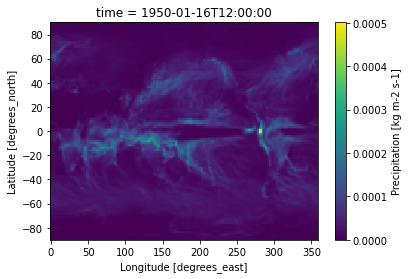

In [32]:
model.pr[0].plot()

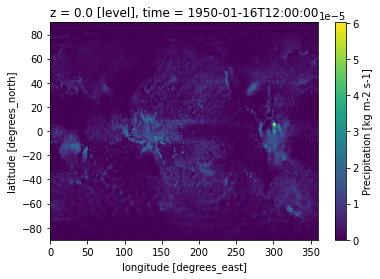

In [11]:
obs.prcp[0].plot()

### Now we can initialize the output array

In [33]:
lat_vals = model.latitude.values
lon_vals = model.longitude.values
pool = 15
# initialize the output data array
mapped_data = np.zeros(shape=(intersection.shape[0], lat_vals.shape[0], lon_vals.shape[0]))
print(f"Output array initialized with shape {mapped_data.shape}")

Output array initialized with shape (350, 180, 120)


In [34]:
max_train_year = np.inf
for day in np.unique(obs['time.dayofyear'].values):
    print(f"Starting day {day}")
    dayrange = (np.arange(day-pool, day+pool+1) + 366) % 366 + 1
    days = np.in1d(obs['time.dayofyear'], dayrange)
    
    subobs = obs.loc[dict(time=days)]
    submodel = model.loc[dict(time=days)]
    
    sub_curr_day_rows = np.where(day == subobs['time.dayofyear'].values)[0]
    curr_day_rows = np.where(day == obs['time.dayofyear'].values)[0]
    train_num = np.where(subobs['time.year'] <= max_train_year)[0][-1]
    mapped_times = subobs['time'].values[sub_curr_day_rows]

    # jobs = [] # list to collect jobs
    tmp_day_mapped = []
    for i, lat in tqdm(enumerate(lat_vals)):
        X_lat = subobs.sel(latitude=lat, longitude=lon_vals, method='nearest')[obs_var].values
        Y_lat = submodel.sel(latitude=lat, longitude=lon_vals)[modeled_var].values
        x_map, y_map = bcsd.qmap_fit(X_lat, Y_lat, axis=0)
        tmp_day_mapped.append(bcsd.qmap_predict(x_map, y_map, Y_lat, axis=0))
        
    # select only those days which correspond to the current day of the year
    day_mapped = np.asarray(tmp_day_mapped)[:, sub_curr_day_rows]
    day_mapped = np.swapaxes(day_mapped, 0, 1)
    mapped_data[curr_day_rows, :, :] = day_mapped


Starting day 16


180it [01:21,  2.22it/s]


Starting day 75


180it [01:27,  2.05it/s]


Starting day 76


180it [01:23,  2.16it/s]


Starting day 136


180it [01:27,  2.06it/s]


Starting day 137


180it [01:20,  2.22it/s]


Starting day 197


180it [01:23,  2.15it/s]


Starting day 198


180it [01:19,  2.25it/s]


Starting day 228


180it [01:20,  2.23it/s]


Starting day 229


180it [01:20,  2.24it/s]


Starting day 289


180it [01:23,  2.16it/s]


Starting day 290


180it [01:20,  2.25it/s]


Starting day 350


180it [01:23,  2.15it/s]


Starting day 351


180it [01:20,  2.23it/s]


In [16]:
# put data into a data array
dr = xr.DataArray(
    mapped_data, 
    coords=[obs['time'].values, lat_vals, lon_vals],
    dims=['time', 'lat', 'lon'])
dr.attrs['gridtype'] = 'latlon'
ds = xr.Dataset({'bias_corrected': dr}) 
ds = ds.reindex_like(model)
# merging aids in preserving netcdf structure
model = model.merge(ds) 
# delete modeled variable to save space
del model[modeled_var]

In [17]:
model.to_netcdf(OUTPUT_PATH)

In [18]:
ds = xr.load_dataset(OUTPUT_PATH)

In [19]:
ds

<xarray.Dataset>
Dimensions:         (time: 350, bnds: 2, longitude: 120, latitude: 180,
                     lat: 180, lon: 120)
Coordinates:
  * time            (time) datetime64[ns] 1950-01-16T12:00:00 ... 1999-12-16T...
  * longitude       (longitude) float64 -89.25 -87.75 -86.25 ... 87.75 89.25
  * latitude        (latitude) float64 0.0 2.0 4.0 6.0 ... 354.0 356.0 358.0
  * lat             (lat) float64 0.0 2.0 4.0 6.0 ... 352.0 354.0 356.0 358.0
  * lon             (lon) float64 -89.25 -87.75 -86.25 ... 86.25 87.75 89.25
Dimensions without coordinates: bnds
Data variables:
    time_bnds       (time, bnds) object 1950-01-01 00:00:00 ... 2000-01-01 00...
    lat_bnds        (longitude, bnds) float64 -90.0 -88.5 -88.5 ... 88.5 90.0
    lon_bnds        (latitude, bnds) float64 -1.0 1.0 1.0 ... 357.0 357.0 359.0
    bias_corrected  (time, lat, lon) float64 1.393e-06 9.945e-07 ... 3.337e-07
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  35405.0
    contact:                Evgeny Volodin (volodinev@gmail.com)
    ...                     ...
    title:                  INM-CM4-8 output prepared for CMIP6
    tracking_id:            hdl:21.14100/29935edf-7e6c-43a4-86a4-78a0cc729e0d
    variable_id:            pr
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by Lawrence Livermore P...
    cmor_version:           3.4.0

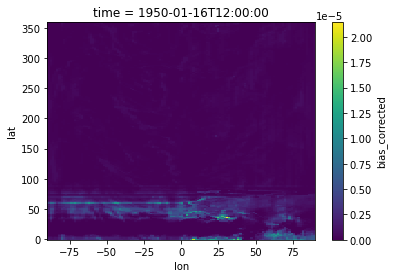

In [22]:
ds.bias_corrected[0].plot()